In [28]:
import numpy as np
import pandas as pd
import os,sys
import argparse
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt


In [29]:
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [30]:
class DataCenter(object):
    """加载数据集
	Parameter:
		file_paths:{数据文件存放地址1,数据文件存放地址2}
	"""
    def __init__(self,file_paths):
        """file_paths:{name:root,...,}"""
        super(DataCenter,self).__init__()
        self.file_paths = file_paths
    
    def load_Dataset(self,dataset='cora'):
        """读取存放在指定路径的数据集"""
        feat_list = [] # 用于存放每个节点特征向量的列表
        label_list = [] # 用于存放每个节点对应类别的列表
        node_map = {} # 将节点进行重新编码
        label_map = {} # 将label映射为数字
        
        if dataset == 'cora':
            content = self.file_paths['cora_content'] # 获取cora_content的地址
            cite = self.file_paths['cora_cite'] # 获取cora_cite的地址
            with open(content) as f1:
                for i,each_sample in enumerate(f1.readlines()): # 遍历每个样本的特征
                    sample_clean = each_sample.strip().split()
                    # 提取每个样本的特征，其中第一个元素和最后一个元素是样本名称和对应的标签
                    feat_list.append(sample_clean[1:-1])
                    # 把节点名称映射为节点编号 
                    node_map[sample_clean[0]]=i
                    label = sample_clean[-1]
                    if label not in label_map.keys():
                    	# 把label转化为数字
                        label_map[label] = len(label_map)
                    label_list.append(label_map[label])
                feat_list = np.asarray(feat_list,dtype=np.float64)
                label_list = np.asarray(label_list,dtype=np.int64)
            
            # 获得每个节点的邻居{v0:[v0的邻居集合],v1:[v1的邻居集合]}
            adj_lists = defaultdict(set)
            with open(cite) as f2:
                for j,each_pair in enumerate(f2.readlines()):
                    pair = each_pair.strip().split()
                    assert len(pair) == 2
                    adj_lists[node_map[pair[0]]].add(node_map[pair[1]])
                    adj_lists[node_map[pair[1]]].add(node_map[pair[0]])
            
            assert len(feat_list) == len(label_list) == len(adj_lists)
            train_index,test_index,val_index = self._split_data(feat_list.shape[0])
            # 使用getattr()可以获得数据
            setattr(self,dataset+'_test',test_index)
            setattr(self,dataset+'_val',val_index)
            setattr(self,dataset+'_train',train_index)
            setattr(self,dataset+'_feats',feat_list)
            setattr(self,dataset+'_labels',label_list)
            setattr(self,dataset+'_adj_lists',adj_lists)
        
    def _split_data(self,number_of_nodes,test_split=3,val_split=6):
        rand_indices = np.random.permutation(number_of_nodes)
        test_size = number_of_nodes // test_split
        val_size = number_of_nodes // val_split
        test_index = rand_indices[:test_size]
        val_index = rand_indices[test_size:test_size+val_size]
        train_index = rand_indices[test_size+val_size:]
        return train_index,test_index,val_index


In [31]:
file_paths = {'cora_content':'./cora.content','cora_cite':'./cora.cites'}
datacenter  = DataCenter(file_paths)
datacenter.load_Dataset()
feature_data = torch.FloatTensor(getattr(datacenter, 'cora'+'_feats'))
label_data = torch.from_numpy(getattr(datacenter,'cora'+'_labels')).long()
adj_lists = getattr(datacenter,'cora'+'_adj_lists')
random.seed(824)
np.random.seed(824)
torch.manual_seed(824)
torch.cuda.manual_seed_all(824)
learn_method = 'sup'
ds = 'cora'
epochs = 50
max_vali_f1=0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ds = 'cora'
test_nodes = getattr(datacenter, ds+'_test')

In [32]:
class UnsupervisedLoss(object):
	"""docstring for UnsupervisedLoss"""
	def __init__(self, adj_lists, train_nodes, device):
		super(UnsupervisedLoss, self).__init__()
		self.Q = 10
		self.N_WALKS = 6
		self.WALK_LEN = 1
		self.N_WALK_LEN = 5
		self.MARGIN = 3
		self.adj_lists = adj_lists
		self.train_nodes = train_nodes
		self.device = device

		self.target_nodes = None
		self.positive_pairs = []
		self.negtive_pairs = []
		self.node_positive_pairs = {}
		self.node_negtive_pairs = {}
		self.unique_nodes_batch = []

	def get_loss_sage(self, embeddings, nodes):
		assert len(embeddings) == len(self.unique_nodes_batch)
		assert False not in [nodes[i]==self.unique_nodes_batch[i] for i in range(len(nodes))]
		node2index = {n:i for i,n in enumerate(self.unique_nodes_batch)}

		nodes_score = []
		assert len(self.node_positive_pairs) == len(self.node_negtive_pairs)
		for node in self.node_positive_pairs:
			pps = self.node_positive_pairs[node]
			nps = self.node_negtive_pairs[node]
			if len(pps) == 0 or len(nps) == 0:
				continue

			# Q * Exception(negative score)
			indexs = [list(x) for x in zip(*nps)]
			node_indexs = [node2index[x] for x in indexs[0]]
			neighb_indexs = [node2index[x] for x in indexs[1]]
			neg_score = F.cosine_similarity(embeddings[node_indexs], embeddings[neighb_indexs])
			neg_score = self.Q*torch.mean(torch.log(torch.sigmoid(-neg_score)), 0)
			#print(neg_score)

			# multiple positive score
			indexs = [list(x) for x in zip(*pps)]
			node_indexs = [node2index[x] for x in indexs[0]]
			neighb_indexs = [node2index[x] for x in indexs[1]]
			pos_score = F.cosine_similarity(embeddings[node_indexs], embeddings[neighb_indexs])
			pos_score = torch.log(torch.sigmoid(pos_score))
			#print(pos_score)

			nodes_score.append(torch.mean(- pos_score - neg_score).view(1,-1))
				
		loss = torch.mean(torch.cat(nodes_score, 0))
		
		return loss

	def get_loss_margin(self, embeddings, nodes):
		assert len(embeddings) == len(self.unique_nodes_batch)
		assert False not in [nodes[i]==self.unique_nodes_batch[i] for i in range(len(nodes))]
		node2index = {n:i for i,n in enumerate(self.unique_nodes_batch)}

		nodes_score = []
		assert len(self.node_positive_pairs) == len(self.node_negtive_pairs)
		for node in self.node_positive_pairs:
			pps = self.node_positive_pairs[node]
			nps = self.node_negtive_pairs[node]
			if len(pps) == 0 or len(nps) == 0:
				continue

			indexs = [list(x) for x in zip(*pps)]
			node_indexs = [node2index[x] for x in indexs[0]]
			neighb_indexs = [node2index[x] for x in indexs[1]]
			pos_score = F.cosine_similarity(embeddings[node_indexs], embeddings[neighb_indexs])
			pos_score, _ = torch.min(torch.log(torch.sigmoid(pos_score)), 0)

			indexs = [list(x) for x in zip(*nps)]
			node_indexs = [node2index[x] for x in indexs[0]]
			neighb_indexs = [node2index[x] for x in indexs[1]]
			neg_score = F.cosine_similarity(embeddings[node_indexs], embeddings[neighb_indexs])
			neg_score, _ = torch.max(torch.log(torch.sigmoid(neg_score)), 0)

			nodes_score.append(torch.max(torch.tensor(0.0).to(self.device), neg_score-pos_score+self.MARGIN).view(1,-1))
			# nodes_score.append((-pos_score - neg_score).view(1,-1))

		loss = torch.mean(torch.cat(nodes_score, 0),0)

		# loss = -torch.log(torch.sigmoid(pos_score))-4*torch.log(torch.sigmoid(-neg_score))
		
		return loss


	def extend_nodes(self, nodes, num_neg=6):
		self.positive_pairs = []
		self.node_positive_pairs = {}
		self.negtive_pairs = []
		self.node_negtive_pairs = {}

		self.target_nodes = nodes
		self.get_positive_nodes(nodes)
		# print(self.positive_pairs)
		self.get_negtive_nodes(nodes, num_neg)
		# print(self.negtive_pairs)
		self.unique_nodes_batch = list(set([i for x in self.positive_pairs for i in x]) | set([i for x in self.negtive_pairs for i in x]))
		assert set(self.target_nodes) < set(self.unique_nodes_batch)
		return self.unique_nodes_batch

	def get_positive_nodes(self, nodes):
		return self._run_random_walks(nodes)

	def get_negtive_nodes(self, nodes, num_neg):
		for node in nodes:
			neighbors = set([node])
			frontier = set([node])
			for i in range(self.N_WALK_LEN):
				current = set()
				for outer in frontier:
					current |= self.adj_lists[int(outer)]
				frontier = current - neighbors
				neighbors |= current
			far_nodes = set(self.train_nodes) - neighbors
			neg_samples = random.sample(far_nodes, num_neg) if num_neg < len(far_nodes) else far_nodes
			self.negtive_pairs.extend([(node, neg_node) for neg_node in neg_samples])
			self.node_negtive_pairs[node] = [(node, neg_node) for neg_node in neg_samples]
		return self.negtive_pairs

	def _run_random_walks(self, nodes):
		for node in nodes:
			if len(self.adj_lists[int(node)]) == 0:
				continue
			cur_pairs = []
			for i in range(self.N_WALKS):
				curr_node = node
				for j in range(self.WALK_LEN):
					neighs = self.adj_lists[int(curr_node)]
					next_node = random.choice(list(neighs))
					# self co-occurrences are useless
					if next_node != node and next_node in self.train_nodes:
						self.positive_pairs.append((node,next_node))
						cur_pairs.append((node,next_node))
					curr_node = next_node

			self.node_positive_pairs[node] = cur_pairs
		return self.positive_pairs

In [33]:
class Classification(nn.Module):

	def __init__(self, emb_size, num_classes):
		super(Classification, self).__init__()

		#self.weight = nn.Parameter(torch.FloatTensor(emb_size, num_classes))
		self.layer = nn.Sequential(
								nn.Linear(emb_size, num_classes)	  
								#nn.ReLU()
							)
		self.init_params()

	def init_params(self):
		for param in self.parameters():
			if len(param.size()) == 2:
				nn.init.xavier_uniform_(param)

	def forward(self, embeds):
		logists = torch.log_softmax(self.layer(embeds), 1)
		return logists

In [34]:
class GraphSage(nn.Module):
	"""docstring for GraphSage"""
	def __init__(self, num_layers, input_size, out_size, raw_features, adj_lists, device, gcn=False, agg_func='MEAN'):
		super(GraphSage, self).__init__()

		self.input_size = input_size
		self.out_size = out_size
		self.num_layers = num_layers
		self.gcn = gcn
		self.device = device
		self.agg_func = agg_func

		self.raw_features = raw_features
		self.adj_lists = adj_lists

		for index in range(1, num_layers+1):
			layer_size = out_size if index != 1 else input_size
			setattr(self, 'sage_layer'+str(index), SageLayer(layer_size, out_size, gcn=self.gcn))

	def forward(self, nodes_batch):
		"""
		Generates embeddings for a batch of nodes.
		nodes_batch	-- batch of nodes to learn the embeddings
		"""
		lower_layer_nodes = list(nodes_batch)
		nodes_batch_layers = [(lower_layer_nodes,)]
		# self.dc.logger.info('get_unique_neighs.')
		for i in range(self.num_layers):
			lower_samp_neighs, lower_layer_nodes_dict, lower_layer_nodes= self._get_unique_neighs_list(lower_layer_nodes)
			nodes_batch_layers.insert(0, (lower_layer_nodes, lower_samp_neighs, lower_layer_nodes_dict))

		assert len(nodes_batch_layers) == self.num_layers + 1

		pre_hidden_embs = self.raw_features
		for index in range(1, self.num_layers+1):
			nb = nodes_batch_layers[index][0]
			pre_neighs = nodes_batch_layers[index-1]
			# self.dc.logger.info('aggregate_feats.')
			aggregate_feats = self.aggregate(nb, pre_hidden_embs, pre_neighs)
			sage_layer = getattr(self, 'sage_layer'+str(index))
			if index > 1:
				nb = self._nodes_map(nb, pre_hidden_embs, pre_neighs)
			# self.dc.logger.info('sage_layer.')
			cur_hidden_embs = sage_layer(self_feats=pre_hidden_embs[nb],
										aggregate_feats=aggregate_feats)
			pre_hidden_embs = cur_hidden_embs

		return pre_hidden_embs

	def _nodes_map(self, nodes, hidden_embs, neighs):
		layer_nodes, samp_neighs, layer_nodes_dict = neighs
		assert len(samp_neighs) == len(nodes)
		index = [layer_nodes_dict[x] for x in nodes]
		return index

	def _get_unique_neighs_list(self, nodes, num_sample=10):
		_set = set
		to_neighs = [self.adj_lists[int(node)] for node in nodes]
		if not num_sample is None:
			_sample = random.sample
			samp_neighs = [_set(_sample(to_neigh, num_sample)) if len(to_neigh) >= num_sample else to_neigh for to_neigh in to_neighs]
		else:
			samp_neighs = to_neighs
		samp_neighs = [samp_neigh | set([nodes[i]]) for i, samp_neigh in enumerate(samp_neighs)]
		_unique_nodes_list = list(set.union(*samp_neighs))
		i = list(range(len(_unique_nodes_list)))
		unique_nodes = dict(list(zip(_unique_nodes_list, i)))
		return samp_neighs, unique_nodes, _unique_nodes_list

	def aggregate(self, nodes, pre_hidden_embs, pre_neighs, num_sample=10):
		unique_nodes_list, samp_neighs, unique_nodes = pre_neighs

		assert len(nodes) == len(samp_neighs)
		indicator = [(nodes[i] in samp_neighs[i]) for i in range(len(samp_neighs))]
		assert (False not in indicator)
		if not self.gcn:
			samp_neighs = [(samp_neighs[i]-set([nodes[i]])) for i in range(len(samp_neighs))]
		# self.dc.logger.info('2')
		if len(pre_hidden_embs) == len(unique_nodes):
			embed_matrix = pre_hidden_embs
		else:
			embed_matrix = pre_hidden_embs[torch.LongTensor(unique_nodes_list)]
		# self.dc.logger.info('3')
		mask = torch.zeros(len(samp_neighs), len(unique_nodes))
		column_indices = [unique_nodes[n] for samp_neigh in samp_neighs for n in samp_neigh]
		row_indices = [i for i in range(len(samp_neighs)) for j in range(len(samp_neighs[i]))]
		mask[row_indices, column_indices] = 1
		# self.dc.logger.info('4')

		if self.agg_func == 'MEAN':
			num_neigh = mask.sum(1, keepdim=True)
			mask = mask.div(num_neigh).to(embed_matrix.device)
			aggregate_feats = mask.mm(embed_matrix)

		elif self.agg_func == 'MAX':
			# print(mask)
			indexs = [x.nonzero() for x in mask==1]
			aggregate_feats = []
			# self.dc.logger.info('5')
			for feat in [embed_matrix[x.squeeze()] for x in indexs]:
				if len(feat.size()) == 1:
					aggregate_feats.append(feat.view(1, -1))
				else:
					aggregate_feats.append(torch.max(feat,0)[0].view(1, -1))
			aggregate_feats = torch.cat(aggregate_feats, 0)

		# self.dc.logger.info('6')
		
		return aggregate_feats

In [35]:
mat1 = torch.randn(2, 3)
mat2 = torch.randn(3, 3)
mat1.mm(mat2)


tensor([[-0.3399,  2.2745, -2.7463],
        [-0.4148,  1.7228, -0.9784]])

In [36]:
class SageLayer(nn.Module):
	"""
	Encodes a node's using 'convolutional' GraphSage approach
	"""
	def __init__(self, input_size, out_size, gcn=False): 
		super(SageLayer, self).__init__()

		self.input_size = input_size
		self.out_size = out_size


		self.gcn = gcn
		self.weight = nn.Parameter(torch.FloatTensor(out_size, self.input_size if self.gcn else 2 * self.input_size))

		self.init_params()

	def init_params(self):
		for param in self.parameters():
			nn.init.xavier_uniform_(param)

	def forward(self, self_feats, aggregate_feats, neighs=None):
		"""
		Generates embeddings for a batch of nodes.
		nodes	 -- list of nodes
		"""
		if not self.gcn:
			combined = torch.cat([self_feats, aggregate_feats], dim=1)
		else:
			combined = aggregate_feats
		combined = F.relu(self.weight.mm(combined.t())).t()
		return combined


In [37]:
def evaluate(dataCenter, ds, graphSage, classification, device, max_vali_f1, name, cur_epoch):
	test_nodes = getattr(dataCenter, ds+'_test')
	val_nodes = getattr(dataCenter, ds+'_val')
	labels = getattr(dataCenter, ds+'_labels')

	models = [graphSage, classification]

	params = []
	for model in models:
		for param in model.parameters():
			if param.requires_grad:
				param.requires_grad = False
				params.append(param)

	embs = graphSage(val_nodes)
	logists = classification(embs)
	_, predicts = torch.max(logists, 1)
	labels_val = labels[val_nodes]
	assert len(labels_val) == len(predicts)
	comps = zip(labels_val, predicts.data)

	vali_f1 = f1_score(labels_val, predicts.cpu().data, average="micro")
	print("Validation F1:", vali_f1)

	if vali_f1 > max_vali_f1:
		max_vali_f1 = vali_f1
		embs = graphSage(test_nodes)
		logists = classification(embs)
		_, predicts = torch.max(logists, 1)
		labels_test = labels[test_nodes]
		assert len(labels_test) == len(predicts)
		comps = zip(labels_test, predicts.data)

		test_f1 = f1_score(labels_test, predicts.cpu().data, average="micro")
		print("Test F1:", test_f1)

		for param in params:
			param.requires_grad = True

		torch.save(models, 'models/model_best_{}_ep{}_{:.4f}.torch'.format(name, cur_epoch, test_f1))

	for param in params:
		param.requires_grad = True

	return max_vali_f1

def get_gnn_embeddings(gnn_model, dataCenter, ds):
    print('Loading embeddings from trained GraphSAGE model.')
    features = np.zeros((len(getattr(dataCenter, ds+'_labels')), gnn_model.out_size))
    nodes = np.arange(len(getattr(dataCenter, ds+'_labels'))).tolist()
    b_sz = 500
    batches = math.ceil(len(nodes) / b_sz)
    embs = []
    for index in range(batches):
        nodes_batch = nodes[index*b_sz:(index+1)*b_sz]
        embs_batch = gnn_model(nodes_batch)
        assert len(embs_batch) == len(nodes_batch)
        embs.append(embs_batch)
        # if ((index+1)*b_sz) % 10000 == 0:
        #     print(f'Dealed Nodes [{(index+1)*b_sz}/{len(nodes)}]')

    assert len(embs) == batches
    embs = torch.cat(embs, 0)
    assert len(embs) == len(nodes)
    print('Embeddings loaded.')
    return embs.detach()

def train_classification(dataCenter, graphSage, classification, ds, device, max_vali_f1, name, epochs=800):
	print('Training Classification ...')
	c_optimizer = torch.optim.SGD(classification.parameters(), lr=0.5)
	# train classification, detached from the current graph
	#classification.init_params()
	b_sz = 50
	train_nodes = getattr(dataCenter, ds+'_train')
	labels = getattr(dataCenter, ds+'_labels')
	features = get_gnn_embeddings(graphSage, dataCenter, ds)
	for epoch in range(epochs):
		train_nodes = shuffle(train_nodes)
		batches = math.ceil(len(train_nodes) / b_sz)
		visited_nodes = set()
		for index in range(batches):
			nodes_batch = train_nodes[index*b_sz:(index+1)*b_sz]
			visited_nodes |= set(nodes_batch)
			labels_batch = labels[nodes_batch]
			embs_batch = features[nodes_batch]

			logists = classification(embs_batch)
			loss = -torch.sum(logists[range(logists.size(0)), labels_batch], 0)
			loss /= len(nodes_batch)
			# print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Dealed Nodes [{}/{}] '.format(epoch+1, epochs, index, batches, loss.item(), len(visited_nodes), len(train_nodes)))

			loss.backward()
			
			nn.utils.clip_grad_norm_(classification.parameters(), 5)
			c_optimizer.step()
			c_optimizer.zero_grad()

		max_vali_f1 = evaluate(dataCenter, ds, graphSage, classification, device, max_vali_f1, name, epoch)
	return classification, max_vali_f1

def apply_model(dataCenter, ds, graphSage, classification, unsupervised_loss, b_sz, unsup_loss, device, learn_method):
	test_nodes = getattr(dataCenter, ds+'_test')
	val_nodes = getattr(dataCenter, ds+'_val')
	train_nodes = getattr(dataCenter, ds+'_train')
	labels = getattr(dataCenter, ds+'_labels')

	if unsup_loss == 'margin':
		num_neg = 6
	elif unsup_loss == 'normal':
		num_neg = 100
	else:
		print("unsup_loss can be only 'margin' or 'normal'.")
		sys.exit(1)

	train_nodes = shuffle(train_nodes)

	models = [graphSage, classification]
	params = []
	for model in models:
		for param in model.parameters():
			if param.requires_grad:
				params.append(param)

	optimizer = torch.optim.SGD(params, lr=0.7)
	optimizer.zero_grad()
	for model in models:
		model.zero_grad()

	batches = math.ceil(len(train_nodes) / b_sz)

	visited_nodes = set()
	visited_nodes.clear()
	for index in range(batches):
		nodes_batch = train_nodes[index*b_sz:(index+1)*b_sz]

		# extend nodes batch for unspervised learning
		# no conflicts with supervised learning
		nodes_batch = np.asarray(list(unsupervised_loss.extend_nodes(nodes_batch, num_neg=num_neg)))
		visited_nodes |= set(nodes_batch)

		# get ground-truth for the nodes batch
		labels_batch = labels[nodes_batch]

		# feed nodes batch to the graphSAGE
		# returning the nodes embeddings
		embs_batch = graphSage(nodes_batch)

		if learn_method == 'sup':
			# superivsed learning
			logists = classification(embs_batch)
			loss_sup = -torch.sum(logists[range(logists.size(0)), labels_batch], 0)
			loss_sup /= len(nodes_batch)
			loss = loss_sup
		elif learn_method == 'plus_unsup':
			# superivsed learning
			logists = classification(embs_batch)
			loss_sup = -torch.sum(logists[range(logists.size(0)), labels_batch], 0)
			loss_sup /= len(nodes_batch)
			# unsuperivsed learning
			if unsup_loss == 'margin':
				loss_net = unsupervised_loss.get_loss_margin(embs_batch, nodes_batch)
			elif unsup_loss == 'normal':
				loss_net = unsupervised_loss.get_loss_sage(embs_batch, nodes_batch)
			loss = loss_sup + loss_net
		else:
			if unsup_loss == 'margin':
				loss_net = unsupervised_loss.get_loss_margin(embs_batch, nodes_batch)
			elif unsup_loss == 'normal':
				loss_net = unsupervised_loss.get_loss_sage(embs_batch, nodes_batch)
			loss = loss_net
		print('Step [{}/{}], Loss: {:.4f}, Dealed Nodes [{}/{}] '.format(index+1, batches, loss.item(), len(visited_nodes), len(train_nodes)))
		loss.backward()
		for model in models:
			nn.utils.clip_grad_norm_(model.parameters(), 5)
		optimizer.step()

		optimizer.zero_grad()
		for model in models:
			model.zero_grad()

	return graphSage, classification

GraphSage with Supervised Learning
----------------------EPOCH 0-----------------------
Step [1/14], Loss: 1.9703, Dealed Nodes [1347/1355] 
Step [2/14], Loss: 1.9240, Dealed Nodes [1355/1355] 
Step [3/14], Loss: 1.8870, Dealed Nodes [1355/1355] 
Step [4/14], Loss: 1.8571, Dealed Nodes [1355/1355] 
Step [5/14], Loss: 1.8301, Dealed Nodes [1355/1355] 
Step [6/14], Loss: 1.8039, Dealed Nodes [1355/1355] 
Step [7/14], Loss: 1.7790, Dealed Nodes [1355/1355] 
Step [8/14], Loss: 1.7525, Dealed Nodes [1355/1355] 
Step [9/14], Loss: 1.7206, Dealed Nodes [1355/1355] 
Step [10/14], Loss: 1.6852, Dealed Nodes [1355/1355] 
Step [11/14], Loss: 1.6465, Dealed Nodes [1355/1355] 
Step [12/14], Loss: 1.6019, Dealed Nodes [1355/1355] 
Step [13/14], Loss: 1.5453, Dealed Nodes [1355/1355] 
Step [14/14], Loss: 1.4881, Dealed Nodes [1355/1355] 
Validation F1: 0.5210643015521065
Test F1: 0.5221729490022173
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.


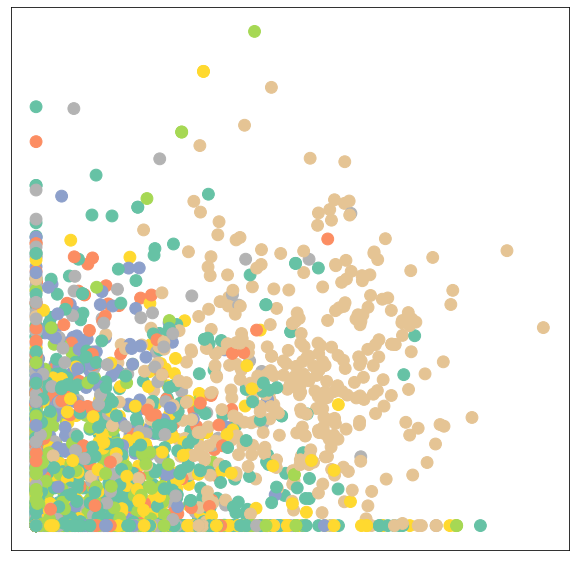

----------------------EPOCH 1-----------------------
Step [1/14], Loss: 1.4122, Dealed Nodes [1343/1355] 
Step [2/14], Loss: 1.3342, Dealed Nodes [1355/1355] 
Step [3/14], Loss: 1.2496, Dealed Nodes [1355/1355] 
Step [4/14], Loss: 1.1664, Dealed Nodes [1355/1355] 
Step [5/14], Loss: 1.0853, Dealed Nodes [1355/1355] 
Step [6/14], Loss: 1.0055, Dealed Nodes [1355/1355] 
Step [7/14], Loss: 0.9311, Dealed Nodes [1355/1355] 
Step [8/14], Loss: 0.8740, Dealed Nodes [1355/1355] 
Step [9/14], Loss: 0.8126, Dealed Nodes [1355/1355] 
Step [10/14], Loss: 0.7625, Dealed Nodes [1355/1355] 
Step [11/14], Loss: 0.7162, Dealed Nodes [1355/1355] 
Step [12/14], Loss: 0.6785, Dealed Nodes [1355/1355] 
Step [13/14], Loss: 0.6495, Dealed Nodes [1355/1355] 
Step [14/14], Loss: 0.6256, Dealed Nodes [1355/1355] 
Validation F1: 0.7915742793791575
Test F1: 0.7638580931263858
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.


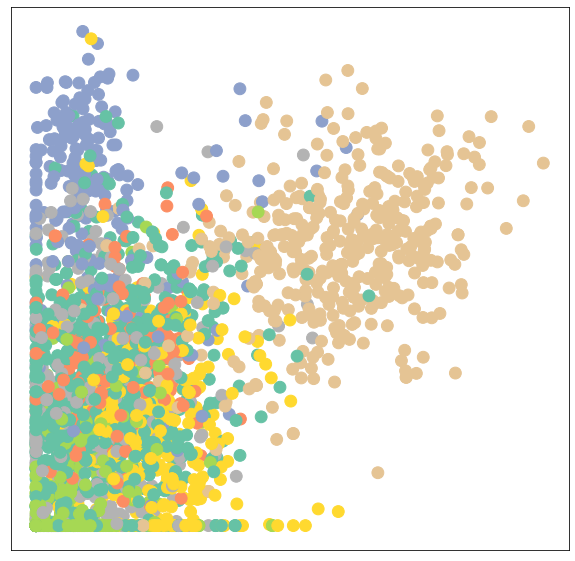

----------------------EPOCH 2-----------------------
Step [1/14], Loss: 0.6663, Dealed Nodes [1347/1355] 
Step [2/14], Loss: 0.7496, Dealed Nodes [1355/1355] 
Step [3/14], Loss: 1.1055, Dealed Nodes [1355/1355] 
Step [4/14], Loss: 0.7667, Dealed Nodes [1355/1355] 
Step [5/14], Loss: 0.6977, Dealed Nodes [1355/1355] 
Step [6/14], Loss: 0.5047, Dealed Nodes [1355/1355] 
Step [7/14], Loss: 0.4725, Dealed Nodes [1355/1355] 
Step [8/14], Loss: 0.4486, Dealed Nodes [1355/1355] 
Step [9/14], Loss: 0.4286, Dealed Nodes [1355/1355] 
Step [10/14], Loss: 0.4145, Dealed Nodes [1355/1355] 
Step [11/14], Loss: 0.3976, Dealed Nodes [1355/1355] 
Step [12/14], Loss: 0.3855, Dealed Nodes [1355/1355] 
Step [13/14], Loss: 0.3745, Dealed Nodes [1355/1355] 
Step [14/14], Loss: 0.3559, Dealed Nodes [1355/1355] 
Validation F1: 0.8758314855875832
Test F1: 0.8614190687361419
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.


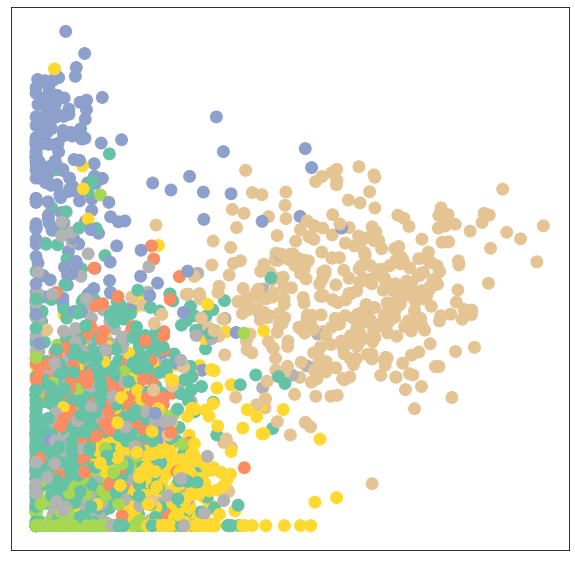

----------------------EPOCH 3-----------------------
Step [1/14], Loss: 0.3538, Dealed Nodes [1346/1355] 
Step [2/14], Loss: 0.3451, Dealed Nodes [1355/1355] 
Step [3/14], Loss: 0.3348, Dealed Nodes [1355/1355] 
Step [4/14], Loss: 0.3252, Dealed Nodes [1355/1355] 
Step [5/14], Loss: 0.3230, Dealed Nodes [1355/1355] 
Step [6/14], Loss: 0.3085, Dealed Nodes [1355/1355] 
Step [7/14], Loss: 0.3044, Dealed Nodes [1355/1355] 
Step [8/14], Loss: 0.2996, Dealed Nodes [1355/1355] 
Step [9/14], Loss: 0.2980, Dealed Nodes [1355/1355] 
Step [10/14], Loss: 0.2857, Dealed Nodes [1355/1355] 
Step [11/14], Loss: 0.2869, Dealed Nodes [1355/1355] 
Step [12/14], Loss: 0.2817, Dealed Nodes [1355/1355] 
Step [13/14], Loss: 0.2789, Dealed Nodes [1355/1355] 
Step [14/14], Loss: 0.2736, Dealed Nodes [1355/1355] 


KeyboardInterrupt: 

In [38]:
file_paths = {'cora_content':'./cora.content','cora_cite':'./cora.cites'}
datacenter  = DataCenter(file_paths)
datacenter.load_Dataset()
feature_data = torch.FloatTensor(getattr(datacenter, 'cora'+'_feats'))
label_data = torch.from_numpy(getattr(datacenter,'cora'+'_labels')).long()
adj_lists = getattr(datacenter,'cora'+'_adj_lists')
random.seed(824)
np.random.seed(824)
torch.manual_seed(824)
torch.cuda.manual_seed_all(824)
learn_method = 'sup'
ds = 'cora'
epochs = 50
max_vali_f1=0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
graphSage = GraphSage(2, feature_data.size(1), 128, feature_data, getattr(datacenter, ds+'_adj_lists'), device, gcn='store_true', agg_func='MEAN')
num_labels = len(set(getattr(datacenter, ds+'_labels')))
classification = Classification(128, num_labels)
unsupervised_loss = UnsupervisedLoss(getattr(datacenter, ds+'_adj_lists'), getattr(datacenter, ds+'_train'), device)
if learn_method == 'sup':
    print('GraphSage with Supervised Learning')
elif learn_method == 'plus_unsup':
    print('GraphSage with Supervised Learning plus Net Unsupervised Learning')
else:
    print('GraphSage with Net Unsupervised Learning')

for epoch in range(epochs):
    print('----------------------EPOCH %d-----------------------' % epoch)
    graphSage, classification = apply_model(datacenter, ds, graphSage, classification, unsupervised_loss, 100, 'normal', device, learn_method)
    if (epoch+1) % 2 == 0 and learn_method == 'unsup':
        classification, max_vali_f1 = train_classification(datacenter, graphSage, classification, ds, device,max_vali_f1, 'debug')
    if learn_method != 'unsup':
        max_vali_f1 = evaluate(datacenter, ds, graphSage, classification, device, max_vali_f1 , 'debug', epoch)
        h=get_gnn_embeddings(graphSage, datacenter, ds)
        visualize(h,color=label_data)



In [40]:
print(feature_data.shape)

torch.Size([2708, 1433])


In [41]:
getattr(datacenter, ds+'_adj_lists')


defaultdict(set,
            {163: {22,
              42,
              55,
              129,
              141,
              145,
              174,
              188,
              189,
              191,
              219,
              237,
              266,
              290,
              309,
              346,
              380,
              390,
              395,
              402,
              415,
              422,
              448,
              523,
              530,
              546,
              563,
              602,
              606,
              624,
              658,
              659,
              689,
              714,
              717,
              727,
              743,
              744,
              757,
              765,
              769,
              781,
              793,
              800,
              813,
              856,
              910,
              935,
              940,
              942,
              961,
            